In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from collections import Counter


sns.set(style='whitegrid')

# 加载数据
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

In [28]:
# 数据清洗与编码
# 删除无关字段
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# 填补缺失值
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# One-hot 编码（转换为数值）
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

In [29]:
# 特征与标签划分 + 数据集划分
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# 初始化森林参数
n_estimators = 10  # 设置树的数量（越多效果越稳定）
max_features = 'sqrt'  # 每棵树随机选择部分特征
random_state = 42

forest = []  # 存储所有训练好的树

np.random.seed(random_state)

for i in range(n_estimators):
    # Bootstrap 有放回采样
    X_sample, y_sample = resample(X_train, y_train, replace=True, random_state=i)
    
    # 创建决策树，使用部分特征
    tree = DecisionTreeClassifier(max_features=max_features, random_state=i)
    tree.fit(X_sample, y_sample)
    
    forest.append(tree)

print(f"成功训练了 {len(forest)} 棵树")

成功训练了 10 棵树


ACURRACY: 0.8044692737430168
REPORT:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



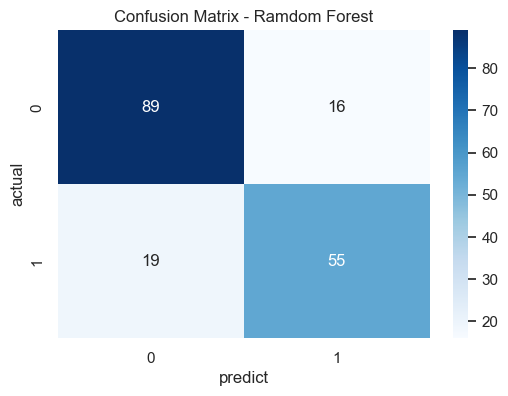

In [31]:
# 所有树在测试集上的预测
all_predictions = [tree.predict(X_test) for tree in forest]
all_predictions = np.array(all_predictions)  # shape: (n_trees, n_samples)

# 对每个样本进行多数投票
y_pred_ensemble = []

for i in range(all_predictions.shape[1]):
    votes = all_predictions[:, i]
    majority_vote = Counter(votes).most_common(1)[0][0]
    y_pred_ensemble.append(majority_vote)

# 评估结果
print("ACURRACY:", accuracy_score(y_test, y_pred_ensemble))
print("REPORT:\n", classification_report(y_test, y_pred_ensemble))

# 可视化混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ramdom Forest')
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

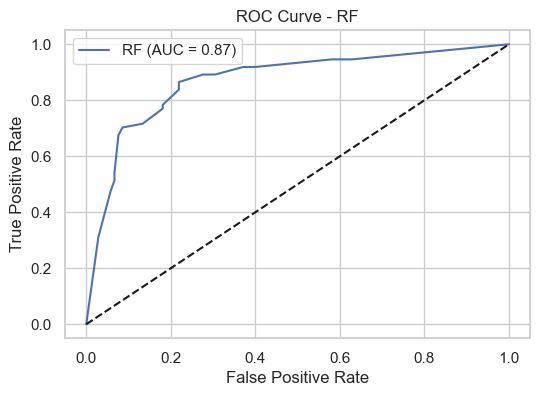

In [25]:
# 获取所有树预测的概率（soft voting）
all_probs = [tree.predict_proba(X_test)[:, 1] for tree in forest]
avg_prob = np.mean(all_probs, axis=0)

fpr, tpr, thresholds = roc_curve(y_test, avg_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF')
plt.legend()
plt.grid(True)
plt.show()